In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
from dataset import CANDataset
import torch
from torchvision import transforms, datasets
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import yaml
from pathlib import Path

In [3]:
wavelet_name = 'gaus1'
with open(f'../configs/{wavelet_name}.yaml') as file:
        cfg = yaml.safe_load(file)

data_dir = Path(f"../{cfg['dataset']['path']}") / wavelet_name / str(cfg['dataset']['id'])
transform = transforms.Normalize(cfg['dataset']['mean'], cfg['dataset']['std'])

In [4]:
train_dataset = CANDataset(
    root_dir=data_dir, is_train=True, transform=transform)
# train_dataset.total_size = 1000
train_sampler = None
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=False,
    num_workers=2, pin_memory=True, sampler=train_sampler)

val_dataset = CANDataset(
    root_dir=data_dir, is_train=False, transform=transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2048, shuffle=False,
    num_workers=8, pin_memory=True, sampler=None)

# Baseline Model

In [5]:
from networks.inception import InceptionResnet
from networks.simple_cnn import BaselineCNNClassifier
from networks.resnet_big import SupCEResNet

In [6]:
# model = InceptionResnet(n_classes = 5)
# baseline_model = BaselineCNNClassifier(n_classes=5)
baseline_model = SupCEResNet(num_classes=5)

In [7]:
model_path = '../save/mexh_resnet181_gamma0_lr0.001_bs256_50epochs_082322_103020_cosine/models/ckpt_epoch_50.pth'
ckpt = torch.load(model_path)
state_dict = ckpt['model']
baseline_model.load_state_dict(state_dict=ckpt['model'])

<All keys matched successfully>

In [8]:
import numpy as np
total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)
# total_embs = np.empty(shape=(0, 128), dtype=float)

baseline_model = baseline_model.cuda()
baseline_model.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(val_loader):
        images = images.cuda(non_blocking=True)
        embs = baseline_model.encoder(images)
        outputs = baseline_model(images)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t().cpu().numpy().squeeze(0)
        embs = embs.cpu().numpy()
        # total_embs = np.concatenate((total_embs, embs), axis=0)
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)

100%|██████████| 174/174 [01:23<00:00,  2.09it/s]


In [9]:
from utils import cal_metric, draw_confusion_matrix
cm, results = cal_metric(total_label, total_pred)
results

{'fnr': array([0.02645527, 0.22779043, 0.32920917, 0.16024061, 0.14207108]),
 'rec': array([0.99973545, 0.9977221 , 0.99670791, 0.99839759, 0.99857929]),
 'pre': array([0.99880151, 0.99969855, 0.99862264, 0.99967911, 0.99979679]),
 'f1': array([0.99926826, 0.99870934, 0.99766436, 0.99903794, 0.99918767])}

In [27]:
classes = ['Normal', 'DoS', 'Fuzzy', 'Gear Spoof', 'RPM Spoof']

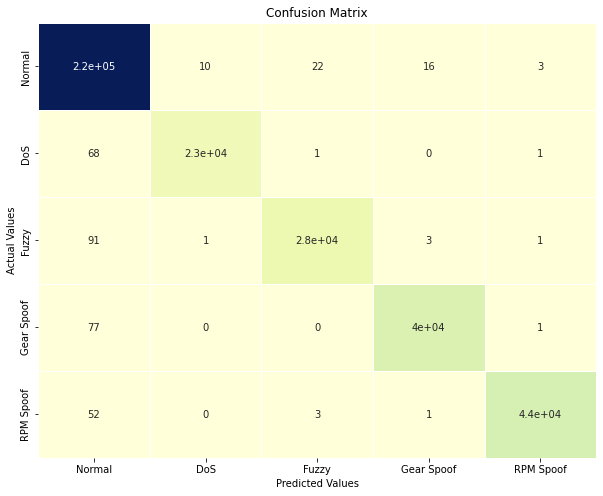

In [29]:
from utils import draw_confusion_matrix
draw_confusion_matrix(cm, classes, save_dir=None)

In [18]:
classes = ['Normal', 'DoS', 'Fuzzy', 'gear', 'RPM']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd',]
n_classes = len(classes)

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

In [19]:
np.random.seed(100)
indices = np.empty(shape=(0), dtype=int)
num_samples = 2000
for c in range(n_classes):
    idx_c = np.where(total_label==c)[0]
    idx_c = np.random.choice(idx_c, num_samples, replace=False)
    indices = np.concatenate((indices, idx_c), axis=0)

In [43]:
total_embs /= 10**18

In [44]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1, perplexity=40)
new_embs = tsne.fit_transform(total_embs[indices])

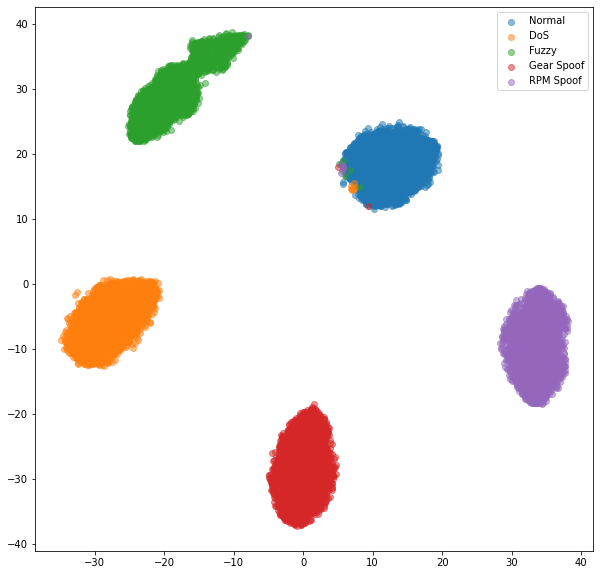

In [46]:
plot_embeddings(new_embs, total_label[indices])
plt.savefig('../figures/tsne_ce.png', dpi=300)

In [26]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [63]:
import torch.optim as optim
from networks.classifier import LinearClassifier
from networks.resnet_big import SupConResNet

model = SupConResNet('resnet18')
classifier = LinearClassifier(n_classes=5, feat_dim=128)

In [64]:
save_path = '../save/SupCon.resnet18.ce1_lr0.05_0.01_bs512_200epoch_temp0.07_052122_214019_cosine_warm/'
ckpt_epoch = 200
# model_path = f'{save_path}/last.pth'
model_path = f'{save_path}/models/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [65]:
class_model_path = f'{save_path}/models/ckpt_class_epoch_{ckpt_epoch}.pth'
# class_model_path = f'{save_path}/last.pth'
ckpt = torch.load(class_model_path)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [66]:
import numpy as np
import tqdm
total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)
total_embs = np.empty(shape=(0, 128), dtype=float)

model = model.cuda()
classifier = classifier.cuda()
model.eval()
classifier.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(val_loader):
        images = images.cuda(non_blocking=True)
        embs = model.encoder(images)
        outputs = classifier(embs)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t().cpu().numpy().squeeze(0)
        embs = embs.cpu().numpy()
        total_embs = np.concatenate((total_embs, embs), axis=0)
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)

100%|██████████| 162/162 [00:48<00:00,  3.36it/s]


In [67]:
from utils import cal_metric
cm, results = cal_metric(total_label, total_pred)
for key, values in results.items():
    print(list("{0:0.4f}".format(i) for i in values)) 

['0.0010', '0.0046', '0.0504', '0.0528', '0.0483']
['1.0000', '1.0000', '0.9995', '0.9995', '0.9995']
['0.9997', '1.0000', '1.0000', '1.0000', '1.0000']
['0.9999', '1.0000', '0.9997', '0.9997', '0.9997']


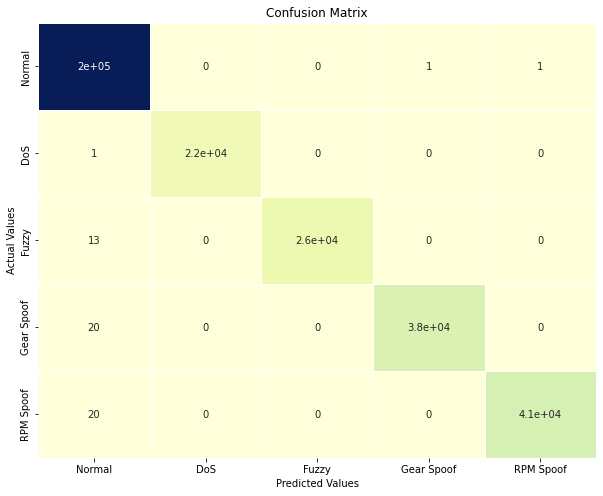

In [68]:
classes = ['Normal', 'DoS', 'Fuzzy', 'Gear Spoof', 'RPM Spoof']
draw_confusion_matrix(cm, classes, save_dir='../figures/confusion_matrix_supcon.png')

In [36]:
total_embs[indices] /= 10**18

In [37]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1, perplexity=40)
new_embs = tsne.fit_transform(total_embs[indices])

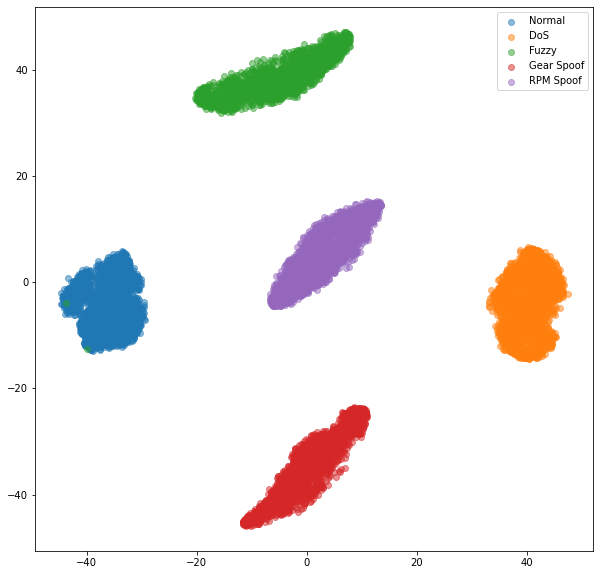

In [39]:
plot_embeddings(new_embs, total_label[indices])
plt.savefig('../figures/tsne_supcon.png', dpi=300)